In [1]:
import tensorflow.compat.v1 as tf

tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)
# from sklearn.metrics import confusion_matrix
import numpy as np
# from scipy.io import loadmat
import os
# from functools import reduce
# from scipy import signal
import pandas as pd
# from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow import keras as K
from tensorflow.keras.layers import Add, Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization, PReLU, ELU, ReLU
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt
# import datetime
# get_ipython().run_line_magic('load_ext', 'tensorboard')
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# get_ipython().run_line_magic('matplotlib', 'inline')
# from collections import Counter 
np_load_old = np.load
# from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
np.random.seed(42)
tf.set_random_seed(42)
from sklearn.metrics import classification_report
import argparse
import h5py

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=36)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=30)
    plt.yticks(tick_marks, classes, fontsize=30)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=28)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

## Load in data

In [3]:
# load new train, validation, and test datasets
loadPath = '/scratch/qh503/deepLearningProject/data_h5/'
bestModel = '/scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_2CNN.pth'

f_train = h5py.File(os.path.join(loadPath, "train1800_raw_EEG.h5"), "r")
tr_data = f_train['data'][:]
ytr = f_train['tasks'][:]
tr_subjects = f_train['subjects'][:]

f_valid = h5py.File(os.path.join(loadPath, "valid360_raw_EEG.h5"), "r")
val_data = f_valid['data'][:]
yval = f_valid['tasks'][:]
val_subjects = f_valid['subjects'][:]

f_test = h5py.File(os.path.join(loadPath, "test360_raw_EEG.h5"), "r")
ts_data = f_test['data'][:]
yts = f_test['tasks'][:]
ts_subjects = f_test['subjects'][:]

## Normalization

In [4]:
# flatten and reshape data
xtr_s_flattened = np.squeeze(tr_data).ravel().reshape((-1, 64))
xval_s_flattened = np.squeeze(val_data).ravel().reshape((-1, 64))
xts_s_flattened = np.squeeze(ts_data).ravel().reshape((-1, 64))
print(xtr_s_flattened.shape)
print(xval_s_flattened.shape)
print(xts_s_flattened.shape)

# normalize data
scaler = StandardScaler()
Ztr_temp = scaler.fit_transform(xtr_s_flattened)
Zval_temp = scaler.transform(xval_s_flattened)
Zts_temp = scaler.transform(xts_s_flattened)

# flatten and reshape data back
Ztr = np.squeeze(Ztr_temp).ravel().reshape((-1, 640, 64))
Zval = np.squeeze(Zval_temp).ravel().reshape((-1, 640, 64))
Zts = np.squeeze(Zts_temp).ravel().reshape((-1, 640, 64))
print(Ztr.shape)
print(Zval.shape)
print(Zts.shape)

(1152000, 64)
(230400, 64)
(230400, 64)
(1800, 640, 64)
(360, 640, 64)
(360, 640, 64)


In [5]:
x_train = Ztr
x_valid = Zval
x_test = Zts
y_train = pd.get_dummies(ytr).values
y_valid = pd.get_dummies(yval).values
y_test = pd.get_dummies(yts).values

## Model architecture

In [6]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [7]:
with strategy.scope():
    nodes = 640
    inputs = Input(shape=(nodes, 64, 1))

    conv1 = Conv2D(8, (15,9), strides=(2,1), kernel_initializer = glorot_uniform(seed=42))(inputs)
    batch1 = BatchNormalization()(conv1)
    prelu1 = PReLU()(batch1)
    maxpool1 = MaxPooling2D((2,2))(prelu1)
    conv2 = Conv2D(16, (15,9), strides=(2,1), kernel_initializer = glorot_uniform(seed=42))(maxpool1)
    batch2 = BatchNormalization()(conv2)
    prelu2 = PReLU()(batch2)
    # maxpool2 = MaxPooling2D((5,1))(prelu2)

    flat = Flatten()(prelu2)
    dense1 = Dense(16, activation='sigmoid', kernel_initializer = glorot_uniform(seed=42))(flat)
    drop1 = Dropout(0.2)(dense1)
    predictions = Dense(4, activation='softmax', kernel_initializer = glorot_uniform(seed=42))(drop1)
    model = Model(inputs=inputs,outputs=predictions)
print(model.summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [8]:
opt_adam = K.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
with strategy.scope():
    model.compile(loss='categorical_crossentropy' , optimizer=opt_adam, metrics=['categorical_accuracy'])
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=30)
mc = ModelCheckpoint(bestModel, monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

In [9]:
history = model.fit(x=x_train, y=y_train, epochs=300, shuffle=True,
                    verbose=1, validation_data = (x_valid, y_valid), callbacks=[es, mc])

Epoch 1/300
57/57 [==============================] - 7s 40ms/step - loss: 1.4184 - categorical_accuracy: 0.2906 - val_loss: 1.3738 - val_categorical_accuracy: 0.2917

Epoch 00001: val_categorical_accuracy improved from -inf to 0.29167, saving model to /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_2CNN.pth
INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_2CNN.pth/assets
Epoch 2/300
57/57 [==============================] - 1s 12ms/step - loss: 1.3272 - categorical_accuracy: 0.3701 - val_loss: 1.3539 - val_categorical_accuracy: 0.3694

Epoch 00002: val_categorical_accuracy improved from 0.29167 to 0.36944, saving model to /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_2CNN.pth
INFO:tensorflow:Assets written to: /scratch/qh503/deepLearningProject/models/baseline_tr1800-val360ts_2CNN.pth/assets
Epoch 3/300
57/57 [==============================] - 1s 12ms/step - loss: 1.2271 - categorical_accuracy: 


Epoch 00028: val_categorical_accuracy did not improve from 0.46111
Epoch 29/300
57/57 [==============================] - 1s 12ms/step - loss: 0.2670 - categorical_accuracy: 0.9856 - val_loss: 1.3191 - val_categorical_accuracy: 0.4111

Epoch 00029: val_categorical_accuracy did not improve from 0.46111
Epoch 30/300
57/57 [==============================] - 1s 12ms/step - loss: 0.2609 - categorical_accuracy: 0.9846 - val_loss: 1.3146 - val_categorical_accuracy: 0.4250

Epoch 00030: val_categorical_accuracy did not improve from 0.46111
Epoch 31/300
57/57 [==============================] - 1s 12ms/step - loss: 0.2499 - categorical_accuracy: 0.9895 - val_loss: 1.3182 - val_categorical_accuracy: 0.4278

Epoch 00031: val_categorical_accuracy did not improve from 0.46111
Epoch 32/300
57/57 [==============================] - 1s 12ms/step - loss: 0.2375 - categorical_accuracy: 0.9894 - val_loss: 1.3371 - val_categorical_accuracy: 0.4361

Epoch 00032: val_categorical_accuracy did not improve from 

## Model testing

In [10]:
best_model = tf.keras.models.load_model(bestModel)
yhat = np.argmax(model.predict(x_test), axis=1)
ytrue = np.argmax(y_test, axis=1)
print('test acc: {:.2f}%'.format(np.sum(yhat == ytrue) / yts.shape[0] * 100))

test acc: 41.67%


In [11]:
target_names = ['open one hand', 'imagine open one hand', 'open both hands/feet', 'imagine open both hands/feet']
print(classification_report(ytrue, yhat, target_names=target_names, digits=4))

                              precision    recall  f1-score   support

               open one hand     0.4270    0.4222    0.4246        90
       imagine open one hand     0.3684    0.3111    0.3373        90
        open both hands/feet     0.4815    0.4333    0.4561        90
imagine open both hands/feet     0.3947    0.5000    0.4412        90

                    accuracy                         0.4167       360
                   macro avg     0.4179    0.4167    0.4148       360
                weighted avg     0.4179    0.4167    0.4148       360



In [12]:
cm = confusion_matrix(ytrue, yhat)
cm

array([[38, 19, 16, 17],
       [26, 28, 12, 24],
       [15,  8, 39, 28],
       [10, 21, 14, 45]])

Normalized confusion matrix
[[0.42222222 0.21111111 0.17777778 0.18888889]
 [0.28888889 0.31111111 0.13333333 0.26666667]
 [0.16666667 0.08888889 0.43333333 0.31111111]
 [0.11111111 0.23333333 0.15555556 0.5       ]]


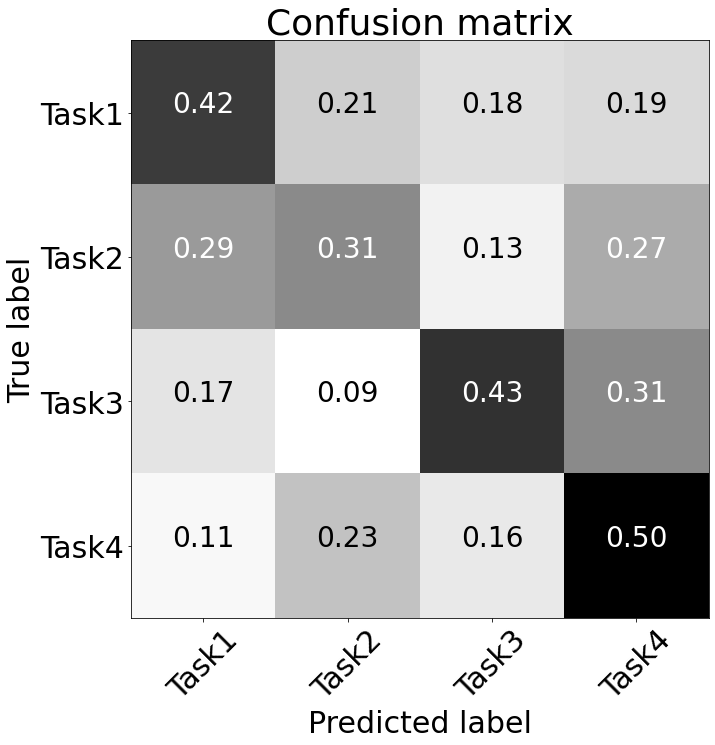

In [13]:
plot_confusion_matrix(cm, ['Task1', 'Task2', 'Task3', 'Task4'], normalize=True, title='Confusion matrix', cmap=plt.cm.Greys)